 # Importing Data 

In [3]:
import tensorflow as tf
import os 
from matplotlib import pyplot as plt
import numpy as np

2024-06-19 13:07:00.833450: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 13:07:01.363258: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 13:07:02.163681: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
os.path.join("data","yes")

'data/yes'

In [5]:
os.listdir("data")

['yes', 'no']

In [6]:
import cv2
import imghdr

/tmp/ipykernel_3853/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data'

In [8]:
image_exts = ["jpeg","jpg","bmp","png"]

In [9]:
img = cv2.imread(os.path.join('data','yes','y0.jpg'))

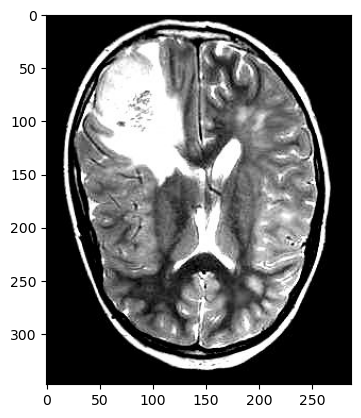

In [10]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [11]:
img.shape

(348, 287, 3)

In [12]:
for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    if os.path.isdir(class_dir):
        for image in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print(f"Image not in extension list: {image_path}")
                    os.remove(image_path)
            except Exception as e:
                print(f"Issue with image {image_path}: {e}")

Issue with image data/yes/.ipynb_checkpoints: [Errno 21] Is a directory: 'data/yes/.ipynb_checkpoints'


In [13]:
data = tf.keras.utils.image_dataset_from_directory("data")

Found 3002 files belonging to 2 classes.


2024-06-19 13:07:06.414568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-19 13:07:06.660945: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

In [16]:
len(batch)

2

In [17]:
batch[0].shape

(32, 256, 256, 3)

In [18]:
#class 0 is no tumor
#class 1 is tumor

batch[1]

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1], dtype=int32)

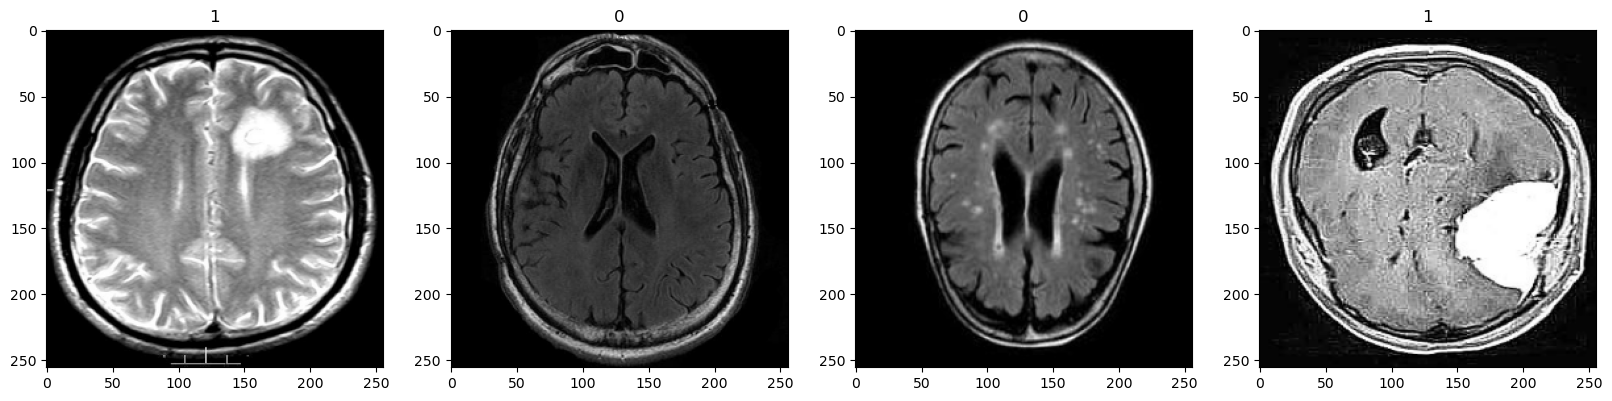

In [19]:
fix, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

 # Preprocessing Data

In [21]:
batch[0].max()

255.0

In [22]:
scaled = batch[0] / 255

In [23]:
scaled.max()

1.0

In [24]:
# scaled data 
data = data.map(lambda x,y: (x/255,y))

In [25]:
scaled_iterator = data.as_numpy_iterator().next()[0].max()

In [26]:
scaled_iterator = data.as_numpy_iterator()

In [27]:
batch = scaled_iterator.next()

In [28]:
batch[0].min()

0.0

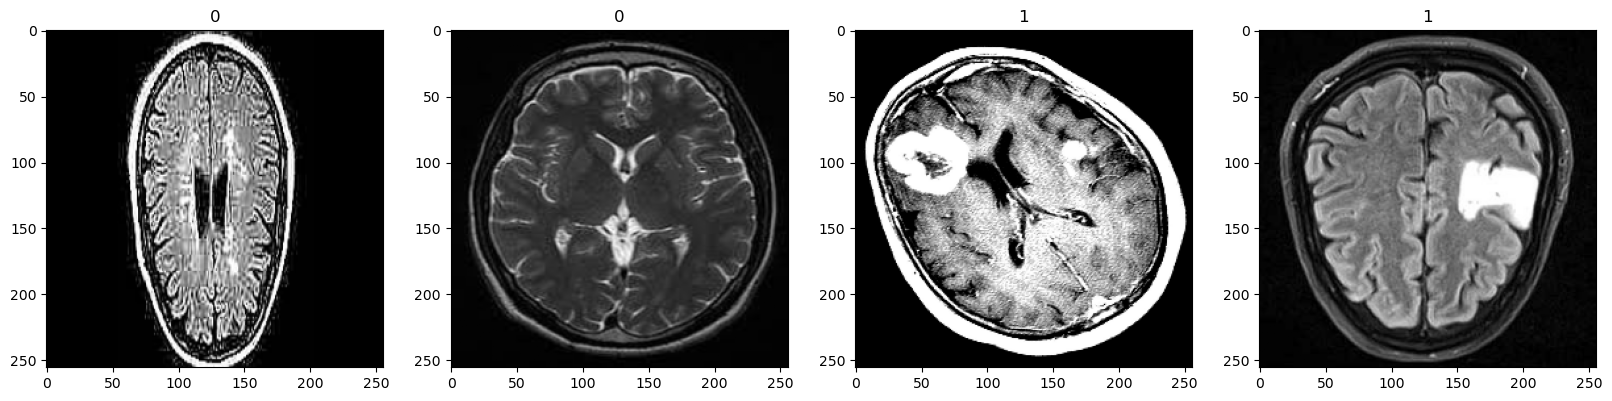

In [29]:
fix, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

 # Splitting data 

In [31]:
len(data)

94

In [32]:
train_size = int(len(data)*.7)-5
val_size = int(len(data)*.2)+7
test_size = int(len(data)*.1)

In [33]:
train_size

60

In [34]:
val_size

25

In [35]:
test_size

9

In [36]:
train_size+val_size+test_size

94

In [37]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

 # Building the deep learning model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.regularizers import l2

In [40]:
model = Sequential()

# Add Conv2D layers with L2 regularization
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())

model.add(Flatten())

# Add Dense layers with L2 regularization and Dropout
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Dropout with 50% rate

model.add(Dense(1, activation='sigmoid'))

/home/parth/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# Traning the model

In [44]:
logdir = 'logs'

In [45]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [46]:
hist = model.fit(train, epochs=20, validation_data=val,callbacks=[tensorboard_callback]) 

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.7081 - loss: 3.0077 - val_accuracy: 0.8200 - val_loss: 0.8796
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.8152 - loss: 0.8194 - val_accuracy: 0.8875 - val_loss: 0.6169
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.8518 - loss: 0.6543 - val_accuracy: 0.8737 - val_loss: 0.6155
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8424 - loss: 0.6679 - val_accuracy: 0.9013 - val_loss: 0.5304
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.8823 - loss: 0.5530 - val_accuracy: 0.9350 - val_loss: 0.4999
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9107 - loss: 0.5084 - val_accuracy: 0.9237 - val_loss: 0.4768
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9252 - loss: 0.4592 - val_accuracy: 0.9325 - val_loss: 0.4980
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.9269 - loss: 0.4679 - val_accuracy: 0.

# Plotting the performance

<function matplotlib.pyplot.show(close=None, block=None)>

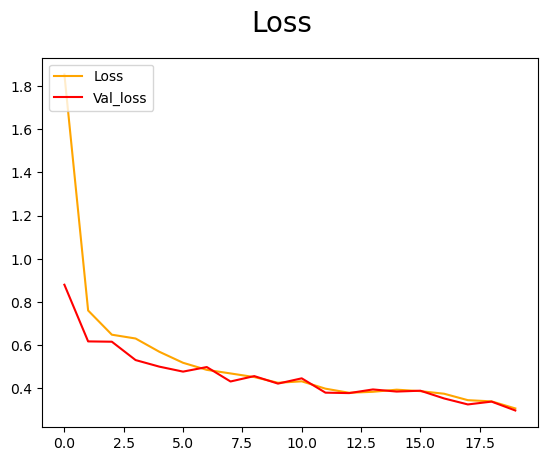

In [48]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='orange', label='Loss')
plt.plot(hist.history['val_loss'] , color ='red', label='Val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc = "upper left")
plt.show

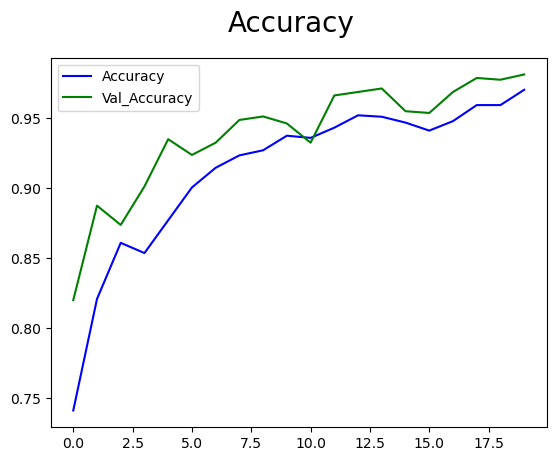

In [49]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='Accuracy')
plt.plot(hist.history['val_accuracy'] , color='green', label = 'Val_Accuracy')
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc = 'upper left')
plt.show()

# Evaluating the performance

In [ ]:
from tensorflow.keras.metrics import Precision, Recall , BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

In [ ]:
# Test

In [ ]:
img = cv2.imread('new_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

In [ ]:
resize = tf.image.resize(img , (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show

In [ ]:
 resize.shape

In [ ]:
np.expand_dims(renp.expand_dims(resize , 0).shapenp.expand_dims(resize , 0).shapesize , 0).shape

In [ ]:
yhat = model.predict(np.expand_dims(resize/255,0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5:
    print(f'the predicted class has tumor')
else:
    print(f"the predicted class has no tumor")

# Saving the model 

In [ ]:
# from tensorflow.keras.models import load_model#

In [ ]:
#model.save(os.path.join('models','tumordetector.h5'))